In [1]:
# initialisations
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, ttest_rel
import random
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import os
import warnings
from plotly.subplots import make_subplots
import pickle
import plotly.graph_objects as go
import plotly.express as px 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn import tree 
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [2]:
sns.set(
    palette="Paired",
    #style='whitegrid',
    color_codes=True,
    rc={"figure.figsize": (12,8)},
)

In [3]:
## import the dataset
url='https://drive.google.com/file/d/1Fsl9G_C7ZzRn0VpfpF8CjuXkdC18Y6Vf/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
compas_df = pd.read_csv(url, sep=',')
compas_df.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


## Preprocessing

In [4]:
# Feature Engineer a more useful category from date of birth
# Data was collected in 2016 therefore age can be determined
# Remove unneccessary month day information- since the age will be from the last minute of 2016
compas_df['DateOfBirth'] = compas_df['DateOfBirth'].str[6:]
# convert to integer and add 1900
compas_df['DateOfBirth'] = pd.to_numeric(compas_df['DateOfBirth'])
compas_df['DateOfBirth'] = compas_df['DateOfBirth'] + 1900

In [5]:
# create new age column
compas_df["Age"] = 2016 - compas_df["DateOfBirth"]

In [6]:
# create a target variable with only two categories
compas_df['ScoreText'].replace('High', 'Medium_High', inplace=True)
compas_df['ScoreText'].replace('Medium', 'Medium_High', inplace=True)

In [7]:
# remove categories which are either unneccessary
compas_df = compas_df.drop(columns=["Person_ID","AssessmentID","Case_ID","FirstName","MiddleName","LastName","DateOfBirth","ScaleSet_ID","Screening_Date","AssessmentReason","RecSupervisionLevel","Scale_ID","IsCompleted","IsDeleted"])

In [8]:
# remove the columns RawScore, DecileScore and RecSupervisionLevelText as give away too much information to the model
compas_df = compas_df.drop(columns=["DecileScore","RecSupervisionLevelText","RawScore"])

In [9]:
compas_df.dtypes

Agency_Text         object
Sex_Code_Text       object
Ethnic_Code_Text    object
ScaleSet            object
Language            object
LegalStatus         object
CustodyStatus       object
MaritalStatus       object
DisplayText         object
ScoreText           object
AssessmentType      object
Age                  int64
dtype: object

In [10]:
# a look at the categories and values so that unknown categories can be removed as a row
for col in compas_df:
    print(col)
    print(compas_df[col].nunique())
    print(compas_df[col].unique())

Agency_Text
4
['PRETRIAL' 'Probation' 'DRRD' 'Broward County']
Sex_Code_Text
2
['Male' 'Female']
Ethnic_Code_Text
9
['Caucasian' 'African-American' 'Hispanic' 'Other' 'Asian' 'African-Am'
 'Native American' 'Oriental' 'Arabic']
ScaleSet
2
['Risk and Prescreen' 'All Scales']
Language
2
['English' 'Spanish']
LegalStatus
7
['Pretrial' 'Post Sentence' 'Conditional Release' 'Other'
 'Probation Violator' 'Parole Violator' 'Deferred Sentencing']
CustodyStatus
6
['Jail Inmate' 'Probation' 'Pretrial Defendant' 'Residential Program'
 'Prison Inmate' 'Parole']
MaritalStatus
7
['Single' 'Married' 'Significant Other' 'Divorced' 'Separated' 'Widowed'
 'Unknown']
DisplayText
3
['Risk of Violence' 'Risk of Recidivism' 'Risk of Failure to Appear']
ScoreText
2
['Low' 'Medium_High' nan]
AssessmentType
2
['New' 'Copy']
Age
71
[24 32 22 31 50 23 44 30 36 38 28 37 46 25 41 43 35 27 56 49 61 42 29 73
 39 33 48 34 45 57 69 54 26 51 53 52 72 62 63 60 83 55 47 20 40 66 58 74
 59 65 87 21 70 68 71 76 67 64 78 79

In [11]:
# size before unknown removal
compas_df.shape[0]

60843

In [12]:
# remove Not a Number categories
compas_df = compas_df.dropna()

In [13]:
# remove unknowns
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Unknown']

In [14]:
# remove 'other' (not useful)
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Other']

In [15]:
compas_df.groupby('Ethnic_Code_Text',sort=False).size()

Ethnic_Code_Text
Caucasian           20436
African-American    25692
Hispanic             6960
Asian                 291
African-Am             51
Native American       198
Oriental               39
Arabic                 75
dtype: int64

In [16]:
# remove the oriental group as the category is so small here
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Oriental']

In [17]:
# remove the arabic group as the category is so small here
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Arabic']

In [18]:
# join the two american american groups as these are in the same category
compas_df['Ethnic_Code_Text'].replace('African-Am', 'African-American', inplace=True)

In [19]:
# size after unknown removal
compas_df.shape[0]

53628

In [20]:
compas_df['ScoreText'].unique()

array(['Low', 'Medium_High'], dtype=object)

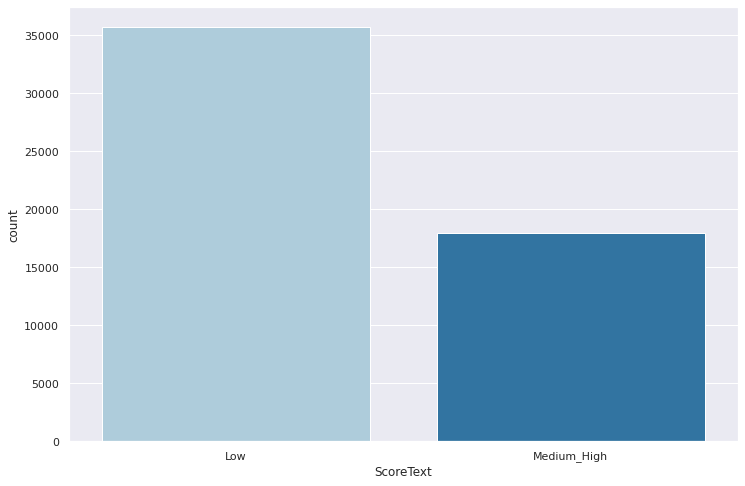

In [21]:
# take a look at the target category
sns.countplot(data=compas_df,x='ScoreText')

In [22]:
# take a look at the target category- seems much fairer
compas_df.ScoreText.value_counts()

Low            35671
Medium_High    17957
Name: ScoreText, dtype: int64

In [23]:
# another look at the refined dataset
compas_df.head()

,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,DisplayText,ScoreText,AssessmentType,Age
0,PRETRIAL,Male,Caucasian,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,Risk of Violence,Low,New,24
1,PRETRIAL,Male,Caucasian,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,Risk of Recidivism,Low,New,24
2,PRETRIAL,Male,Caucasian,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,Risk of Failure to Appear,Low,New,24
3,PRETRIAL,Male,Caucasian,Risk and Prescreen,English,Pretrial,Jail Inmate,Married,Risk of Violence,Low,New,32
4,PRETRIAL,Male,Caucasian,Risk and Prescreen,English,Pretrial,Jail Inmate,Married,Risk of Recidivism,Low,New,32


### Label Encoder

In [24]:
# label encode the categorcal variables so that they can be fed into the decision tree model
le = LabelEncoder()
compas_df.Agency_Text = le.fit_transform(compas_df.Agency_Text)
compas_df.Sex_Code_Text = le.fit_transform(compas_df.Sex_Code_Text)
compas_df.Ethnic_Code_Text = le.fit_transform(compas_df.Ethnic_Code_Text)
compas_df.ScaleSet = le.fit_transform(compas_df.ScaleSet)
compas_df.Language = le.fit_transform(compas_df.Language)
compas_df.LegalStatus = le.fit_transform(compas_df.LegalStatus)
compas_df.CustodyStatus = le.fit_transform(compas_df.CustodyStatus)
compas_df.MaritalStatus = le.fit_transform(compas_df.MaritalStatus)
compas_df.DisplayText = le.fit_transform(compas_df.DisplayText)
compas_df.ScoreText = le.fit_transform(compas_df.ScoreText)
compas_df.AssessmentType = le.fit_transform(compas_df.AssessmentType)

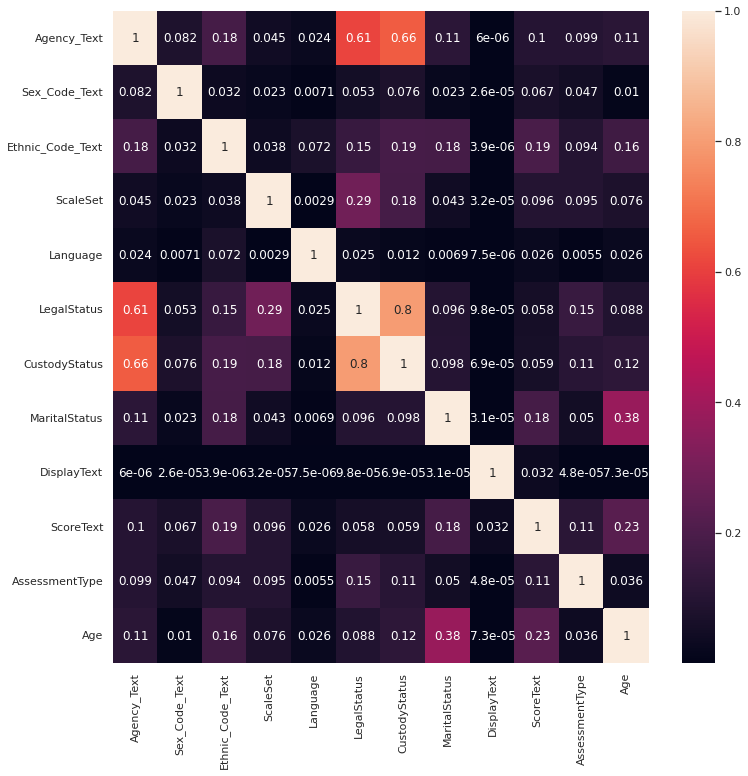

In [25]:
# a correlation heatmap can now be created after the preprocessing steps for further EDA
plt.figure(figsize=(12,12))
map = sns.heatmap(compas_df.corr().abs(),annot=True)

### Split data

In [26]:
# perform a split of the data into training and test data
X = compas_df.drop('ScoreText',axis=1)
y = compas_df[['ScoreText']]

K-Fold

In [27]:
# do a stratified k fold to allow for more even train and test groups in terms of the target category
KF = StratifiedKFold(n_splits=3,shuffle=True,random_state=64)
for train_index, test_index in KF.split(X, y):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [28]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(35752, 11)
Test data shape:(17876, 11)


Scaling data

In [29]:
# scale the training and test data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

## Decision Tree Model

In [30]:
# define the model
dt = DecisionTreeClassifier()

In [31]:
# fit the model
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [32]:
# perform predictions of the test data
pred = dt.predict(scaled_test)

In [33]:
# calculate the accuracy of the predictions by comparing to the test data
accuracy_score(y_test,pred)

0.7249384649809801

In [34]:
# define the grid search parameters
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [35]:
# perform the grid search
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [36]:
# display best parameters found from the grid search
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'random_state': 0, 'splitter': 'random'} 


In [37]:
# define the tuned decision tree with new parameters
dt_tuned =  DecisionTreeClassifier(criterion='gini',
                                   min_samples_split=2,
                                   max_depth=8,
                                   max_features = None,
                                   min_samples_leaf=10,
                                   random_state = 0,
                                   splitter='random')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=10, random_state=0,
                       splitter='random')

In [38]:
# create the new predictions
pred = dt_tuned.predict(scaled_test)

In [39]:
# display the accuracy of the tuned model
accuracy_score(y_test,pred)

0.746979189975386

In [40]:
# display a classification report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.77      0.89      0.82     11890
           1       0.68      0.47      0.55      5986

    accuracy                           0.75     17876
   macro avg       0.72      0.68      0.69     17876
weighted avg       0.74      0.75      0.73     17876



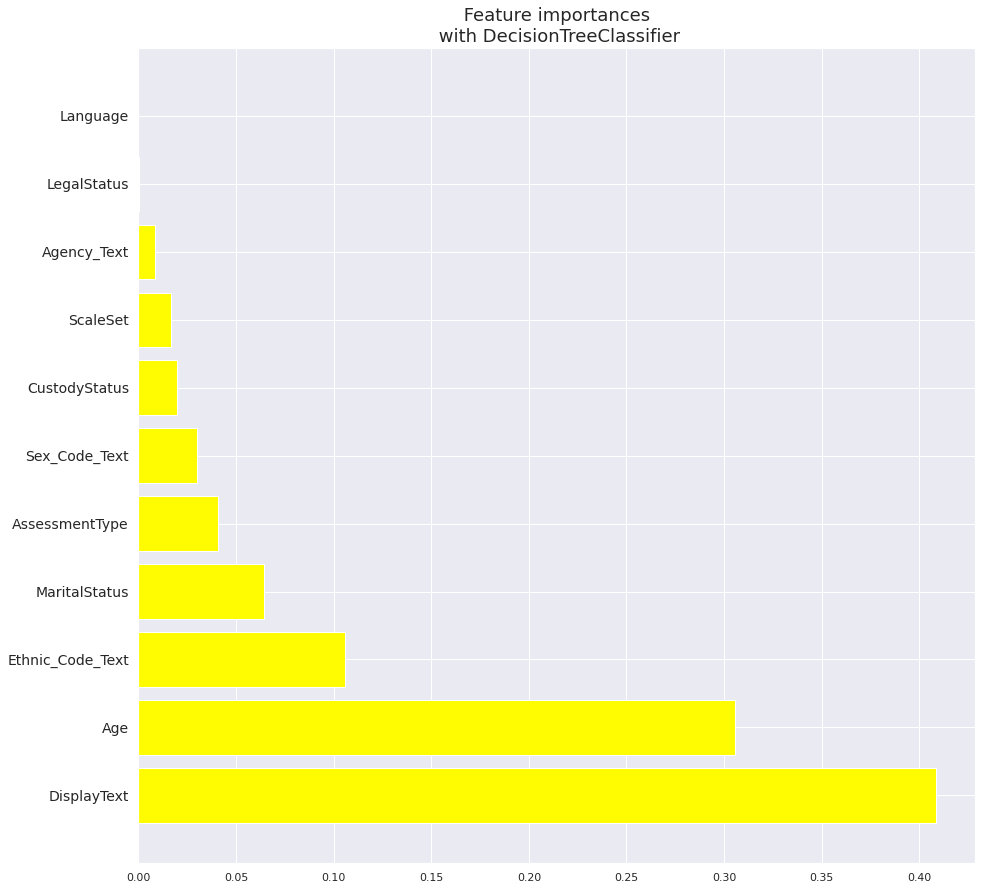

In [41]:
# display feature importance for the model
tree_model = dt_tuned.fit(scaled_train, y_train)
importances = tree_model.feature_importances_
feature_names = compas_df.drop('ScoreText', axis=1).columns
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(15,15))
    plt.title(" Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#fffb00',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()

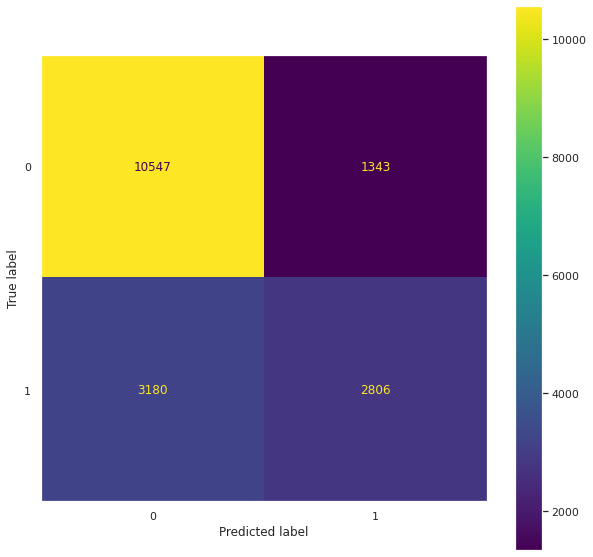

In [42]:
# display a confusion matrix to show where the predictions lie
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(dt_tuned,scaled_test,y_test,ax=ax)

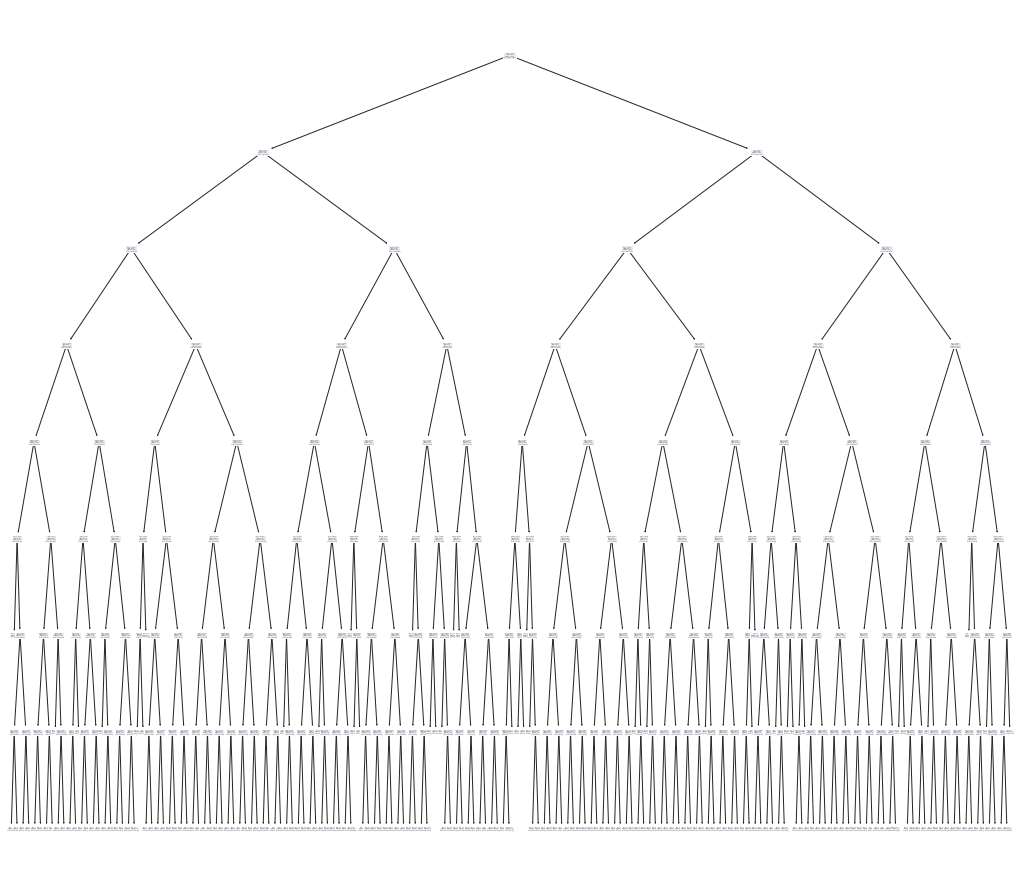

In [43]:
# example of the decision tree classifier display
plt.figure(figsize = (18, 16))
tree.plot_tree(dt_tuned)
plt.show()

In [44]:
# create a reults dataframe to compare accuracies of the different subgroups in the protected category
ethnic_results = pd.DataFrame(data = x_test, columns=['Ethnic_Code_Text'])
ethnic_results['y_test'] = y_test
ethnic_results['pred'] = pred

In [45]:
ethnic_results['y_test'].replace(0, 'High/Medium', inplace=True)
ethnic_results['y_test'].replace(1, 'Low', inplace=True)
ethnic_results['pred'].replace(0, 'High/Medium', inplace=True)
ethnic_results['pred'].replace(1, 'Low', inplace=True)
ethnic_results['Ethnic_Code_Text'].replace(0, 'African_American', inplace=True)
ethnic_results['Ethnic_Code_Text'].replace(1, 'Asian', inplace=True)
ethnic_results['Ethnic_Code_Text'].replace(2, 'Caucasian', inplace=True)
ethnic_results['Ethnic_Code_Text'].replace(3, 'Hispanic', inplace=True)
ethnic_results['Ethnic_Code_Text'].replace(4, 'Native_American', inplace=True)

ethnic_results.head()

,Ethnic_Code_Text,y_test,pred
1,Caucasian,High/Medium,Low
3,Caucasian,High/Medium,High/Medium
8,African_American,High/Medium,High/Medium
11,African_American,High/Medium,High/Medium
13,African_American,High/Medium,Low


In [46]:
# create a dataframe of only caucasian predicted and true values
ethnic_results_cauc = ethnic_results[ethnic_results['Ethnic_Code_Text']=='Caucasian']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
ethnic_results_cauc['true']  = np.where((ethnic_results_cauc['y_test'] == ethnic_results_cauc['pred']), 1, 0)
# calculate percentage of correct classifications
cauc_accuracy = (sum(ethnic_results_cauc['true'])/ethnic_results_cauc.shape[0])*100
cauc_accuracy

78.35744556481076

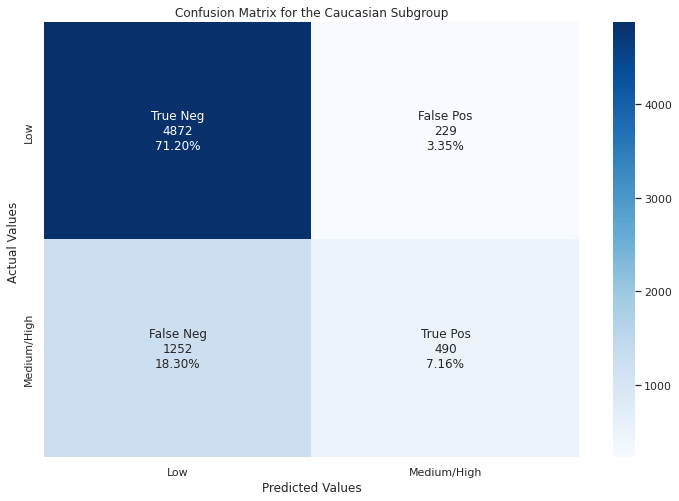

In [47]:
# a confusion matrix of one of the subgroups in the protected category
y_test = ethnic_results_cauc['y_test']
pred = ethnic_results_cauc['pred']
cauc_cf = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cauc_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cauc_cf.flatten()/np.sum(cauc_cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cauc_cf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for the Caucasian Subgroup');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Low','Medium/High'])
ax.yaxis.set_ticklabels(['Low','Medium/High'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [48]:
# create a dataframe of only african american predicted and true values
ethnic_results_afr = ethnic_results[ethnic_results['Ethnic_Code_Text']=='African_American']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
ethnic_results_afr['true']  = np.where((ethnic_results_afr['y_test'] == ethnic_results_afr['pred']), 1, 0)
# calculate percentage of correct classifications
afr_accuracy = (sum(ethnic_results_afr['true'])/ethnic_results_afr.shape[0])*100
afr_accuracy

70.04436142890498

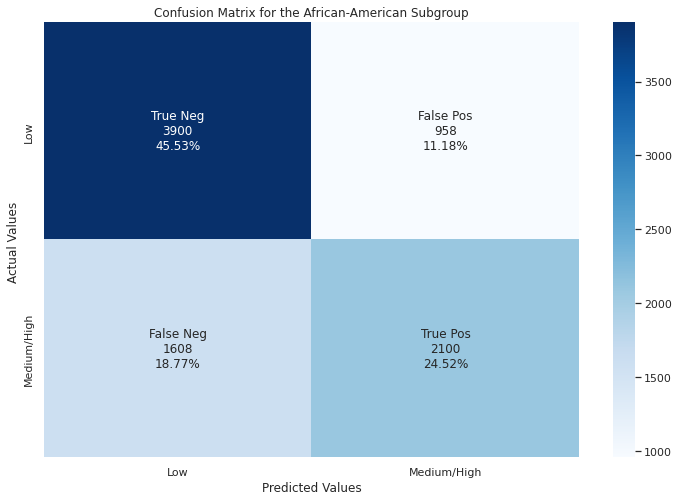

In [49]:
# a confusion matrix of one of the subgroups in the protected category
y_test = ethnic_results_afr['y_test']
pred = ethnic_results_afr['pred']
afr_cf = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                afr_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     afr_cf.flatten()/np.sum(afr_cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(afr_cf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for the African-American Subgroup');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Low','Medium/High'])
ax.yaxis.set_ticklabels(['Low','Medium/High'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [50]:
# create a dataframe of only hispanic predicted and true values
ethnic_results_his = ethnic_results[ethnic_results['Ethnic_Code_Text']=='Hispanic']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
ethnic_results_his['true']  = np.where((ethnic_results_his['y_test'] == ethnic_results_his['pred']), 1, 0)
# calculate percentage of correct classifications
his_accuracy = (sum(ethnic_results_his['true'])/ethnic_results_his.shape[0])*100
his_accuracy

80.98530682800346

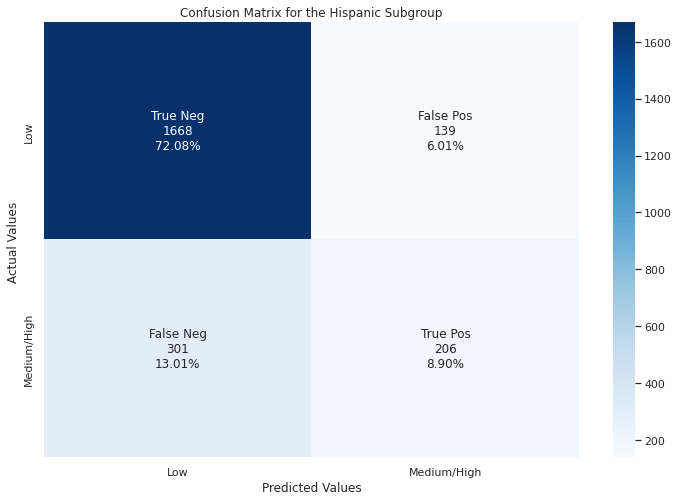

In [51]:
# a confusion matrix of one of the subgroups in the protected category
y_test = ethnic_results_his['y_test']
pred = ethnic_results_his['pred']
his_cf = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                his_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     his_cf.flatten()/np.sum(his_cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(his_cf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for the Hispanic Subgroup');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Low','Medium/High'])
ax.yaxis.set_ticklabels(['Low','Medium/High'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [52]:
# create a dataframe of only asian predicted and true values
ethnic_results_asi = ethnic_results[ethnic_results['Ethnic_Code_Text']=='Asian']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
ethnic_results_asi['true']  = np.where((ethnic_results_asi['y_test'] == ethnic_results_asi['pred']), 1, 0)
# calculate percentage of correct classifications
asi_accuracy = (sum(ethnic_results_asi['true'])/ethnic_results_asi.shape[0])*100
asi_accuracy

80.61224489795919

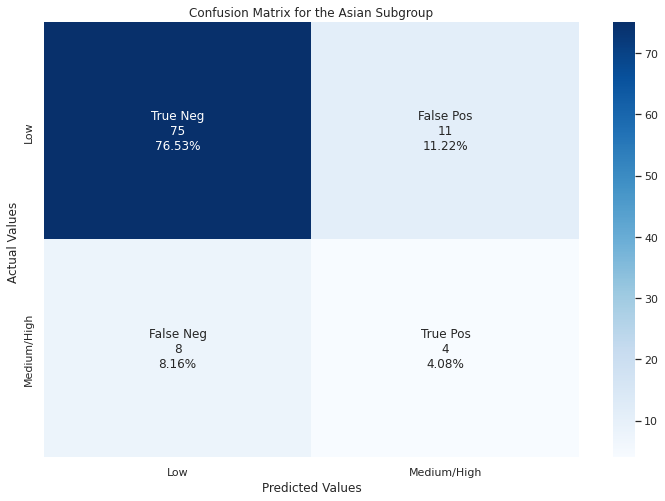

In [53]:
# a confusion matrix of one of the subgroups in the protected category
y_test = ethnic_results_asi['y_test']
pred = ethnic_results_asi['pred']
asi_cf = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                asi_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     asi_cf.flatten()/np.sum(asi_cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(asi_cf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for the Asian Subgroup');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Low','Medium/High'])
ax.yaxis.set_ticklabels(['Low','Medium/High'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [54]:
# the test group did not have any natve americans so this step is redundant
# create a dataframe of only native american predicted and true values
#ethnic_results_nat = ethnic_results[ethnic_results['Ethnic_Code_Text']=='Native_American']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
#ethnic_results_nat['true']  = np.where((ethnic_results_nat['y_test'] == ethnic_results_nat['pred']), 1, 0)
# calculate percentage of correct classifications
#nat_accuracy = (sum(ethnic_results_nat['true'])/ethnic_results_nat.shape[0])*100
#nat_accuracy

In [55]:
# show all subgroup accuracies in one table for clarity
from tabulate import tabulate
data = [['Caucasian', cauc_accuracy],
['African-American', afr_accuracy],
['Hispanic', his_accuracy],
['Asian', asi_accuracy],
#['Native-American', nat_accuracy],
]
print (tabulate(data, headers=["Ethnicity", "Classification Accuracy"]))

Ethnicity           Classification Accuracy
----------------  -------------------------
Caucasian                           78.3574
African-American                    70.0444
Hispanic                            80.9853
Asian                               80.6122
